In [138]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, MultiPolygon
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.ops import unary_union
import time

subfuction

In [139]:
def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

def init_sample_area(x_range,y_range):
    # 创建一个矩形多边形
    rectangle = box(x_range[0], y_range[0], x_range[1], y_range[1])

    # 将矩形多边形包装在一个 MultiPolygon 中
    multipolygon = MultiPolygon([rectangle])
    return multipolygon



def simplify_polygon(polygon, tolerance):
    """使用Douglas-Peucker算法简化多边形"""
    return polygon.simplify(tolerance, preserve_topology=True)

def random_sampling_within_multipolygon(multipolygon, num_samples, tolerance=0.01):
    # 判断是单个多边形还是多多边形，并进行简化
    polygons = [simplify_polygon(multipolygon, tolerance)] if isinstance(multipolygon, Polygon) else [simplify_polygon(p, tolerance) for p in multipolygon.geoms]

    # 确定每个子多边形的样本数
    total_area = sum(p.area for p in polygons)
    sample_counts = [int(p.area / total_area * num_samples) for p in polygons]

    points = []
    for polygon, num_samples_in_polygon in zip(polygons, sample_counts):
        minx, miny, maxx, maxy = polygon.bounds
        samples_in_current_polygon = 0
        while samples_in_current_polygon < num_samples_in_polygon:
            real = np.random.uniform(minx, maxx)
            imag = np.random.uniform(miny, maxy)
            point = Point(real, imag)
            if polygon.contains(point):
                complex_point = real + imag * 1j
                points.append(complex_point)
                samples_in_current_polygon += 1

    return points



#定义采样结果
def random_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]
    inside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability == max_iter]
    boundary_points = [points[i] for i, stability in enumerate(stabilities) if iteration_threshold < stability < max_iter]
    outside_mandelbrot = [points[i] for i, stability in enumerate(stabilities) if stability <= iteration_threshold]
    return np.array(inside_mandelbrot), np.array(boundary_points), np.array(outside_mandelbrot)

#对于采样结果分成小正方形的集合
def define_regions(points, side_length):
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    squares = []
    half_side = side_length / 2

    for point in points:
        left = max(point.real - half_side, x_range[0])
        right = min(point.real + half_side, x_range[1])
        bottom = max(point.imag - half_side, y_range[0])
        top = min(point.imag + half_side, y_range[1])

        # 仅当方形在定义的范围内时才添加
        if left < right and bottom < top:
            squares.append([left, right, bottom, top])

    return squares

#将小正方形的集合转为MultiPolygon格式
def merge_squares(squares, current_sample_space):
    polygons = [Polygon([(left, bottom), (right, bottom), (right, top), (left, top)]) for left, right, bottom, top in squares]
    merged_area = unary_union(polygons)

    # 使用intersection方法获取合并区域与current_sample_space的交集
    intersection = merged_area.intersection(current_sample_space)

    if isinstance(intersection, MultiPolygon):
        return intersection
    elif isinstance(intersection, Polygon):
        return MultiPolygon([intersection])
    else:
        return MultiPolygon([])  # 返回空的MultiPolygon对象
    
#处理生成的三个MultiPolygon区域
def adjust_spaces(inside_space, boundary_space, outside_space, init_space):
    # Step 1: Add intersection with boundary_space to boundary_space
    boundary_inside_intersection = boundary_space.intersection(inside_space)
    boundary_outside_intersection = boundary_space.intersection(outside_space)
    boundary_space = boundary_space.union(boundary_inside_intersection).union(boundary_outside_intersection)

    # Step 2: Remove intersection with boundary_space from inside_space and outside_space
    inside_space = inside_space.difference(boundary_inside_intersection)
    outside_space = outside_space.difference(boundary_outside_intersection)

    # Step 3: Add intersection between inside_space and outside_space to boundary_space
    inside_outside_intersection = inside_space.intersection(outside_space)
    boundary_space = boundary_space.union(inside_outside_intersection)

    # Remove intersections from inside_space and outside_space
    inside_space = inside_space.difference(inside_outside_intersection)
    outside_space = outside_space.difference(inside_outside_intersection)

    # Step 4: Calculate the difference between the union of all spaces and init_space
    union_of_spaces = inside_space.union(boundary_space).union(outside_space)
    difference = union_of_spaces.difference(init_space)

    # Step 5: Add the difference to boundary_space
    boundary_space = boundary_space.union(difference)
    
    return inside_space, boundary_space, outside_space

#进行每轮的可视化绘图
def visualize_space(merged_rectangles, ax, color='blue'):
    # 如果是单个 Polygon，将其放入一个列表中
    if isinstance(merged_rectangles, Polygon):
        merged_rectangles = [merged_rectangles]
    # 如果是 MultiPolygon，提取每个 Polygon
    elif isinstance(merged_rectangles, MultiPolygon):
        merged_rectangles = [polygon for polygon in merged_rectangles.geoms]

    # 绘制并填充每个多边形
    for polygon in merged_rectangles:
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color, alpha=0.5)  # 填充外部多边形

        for interior in polygon.interiors:
            x, y = interior.xy
            ax.fill(x, y, color='white', alpha=1)  # 使用白色填充内部多边形以创建空洞效果

def final_sampling(multipolygon, num_samples, max_iter, iteration_threshold):
    points = random_sampling_within_multipolygon(multipolygon, num_samples)
    stabilities = [mandelbrot(c, max_iter) for c in points]

    # Count the number of points inside the Mandelbrot set
    count_inside_mandelbrot = sum(1 for stability in stabilities if stability == max_iter)

    # Calculate the probability of a point being inside the Mandelbrot set
    probability_inside_mandelbrot = count_inside_mandelbrot / num_samples
    last_area = probability_inside_mandelbrot * multipolygon.area
    return last_area




main function

In [145]:
def main():
    x_range = [-2, 1]
    y_range = [-1.5, 1.5]
    num_samples = 1000
    max_iter = 2000
    init_area_of_sample = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    init_space = MultiPolygon([box(x_range[0], y_range[0], x_range[1], y_range[1])])


    sampletime = 20
    aim_samplesize = []
    true_samplesize = []
    inside = []
    outside = []
    boundary = []
    beta = 7
    last_sample = 1
    unknowarea = 0
    for i in range(sampletime):
        if i == 0:
            current_sample_space = init_space
            current_area_size = init_area_of_sample
        else:
            current_sample_space = adjusted_boundary_space
            current_area_size = adjusted_boundary_space.area

        aim_samplesize.append(current_sample_space)
        iteration_threshold = (i + 1) * 5
        #print(f"circle {i+1}")

        if i > 1 : 
            if adjusted_inside_space.area / current_area_size <= 0.1:
                beta *= 1.05
            else:
                beta *= 0.9
        #print(f"beta = {beta}")
        side_length = current_area_size / beta

        

        start_time = time.time() 
        #print(current_sample_space)
        inside_mandelbrot, boundary_points , outside_mandelbrot= random_sampling(current_sample_space, 
                                                        num_samples, max_iter, iteration_threshold)

        end_time = time.time()  # 结束时间
        elapsed_time = end_time - start_time  # 计算经过的时间

        #print(f"part0代码运行时间: {elapsed_time}秒")
        """
        plt.figure(figsize=(10, 10))

        # Plot each set of points with different colors
        plt.scatter(inside_mandelbrot.real, inside_mandelbrot.imag, color='green', s=0.5, label='Inside Mandelbrot')
        plt.scatter(boundary_points.real, boundary_points.imag, color='blue', s=0.5, label='Boundary of Mandelbrot')
        plt.scatter(outside_mandelbrot.real, outside_mandelbrot.imag, color='red', s=0.5, label='Outside Mandelbrot')

        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.title('Visualization of the Mandelbrot Set')
        plt.xlabel('Real part')
        plt.ylabel('Imaginary part')
        plt.legend()
        plt.show()
        
        """
        start_time = time.time() 

        inside_mandelbrot_squares = define_regions(inside_mandelbrot, side_length)
        boundary_squares = define_regions(boundary_points, side_length)  # 0.1 is the length of the side of the square area
        outside_mandelbrot_squares = define_regions(outside_mandelbrot, side_length)
        """
        def visualize_regions(squares, color):
            fig, ax = plt.subplots(figsize=(10, 10))

            # Draw each square
            for square in squares:
                left, right, bottom, top = square
                square_patch = plt.Rectangle((left, bottom), right - left, top - bottom, 
                                            edgecolor=color, facecolor='none')
                ax.add_patch(square_patch)

            ax.set_xlim(x_range)
            ax.set_ylim(y_range)
            plt.xlabel('Real part')
            plt.ylabel('Imaginary part')
            plt.title('Regions in the Mandelbrot Set')
            plt.show()
        """
        # Visualize each set of regions
        #visualize_regions(inside_mandelbrot_squares, 'green')
        #visualize_regions(boundary_squares, 'blue')
        #visualize_regions(outside_mandelbrot_squares, 'red')

        #????????????
        inside_space = merge_squares(inside_mandelbrot_squares, current_sample_space)
        boundary_space = merge_squares(boundary_squares, current_sample_space)
        outside_space = merge_squares(outside_mandelbrot_squares, current_sample_space)
        
        #print(inside_space)
        #print(boundary_space)
        #print(current_sample_space)

        end_time = time.time()  # 结束时间
        elapsed_time = end_time - start_time  # 计算经过的时间

        #print(f"part1代码运行时间: {elapsed_time}秒")


        start_time = time.time()  # 开始时间


        adjusted_inside_space, adjusted_boundary_space, adjusted_outside_space = adjust_spaces(inside_space,
                                                            boundary_space, outside_space, current_sample_space)
        
        
        end_time = time.time()  # 结束时间
        elapsed_time = end_time - start_time  # 计算经过的时间

        #print(f"part2,adjust代码运行时间: {elapsed_time}秒")
        
        inside.append(adjusted_inside_space.area)
        boundary.append(adjusted_boundary_space.area)
        outside.append(adjusted_outside_space.area)
        
        #print(f"Adjusted Inside Mandelbrot Set Area: {adjusted_inside_space.area}")
        #print(f"Adjusted Boundary of Mandelbrot Set Area: {adjusted_boundary_space.area}")
        #print(f"Adjusted Outside Mandelbrot Set Area: {adjusted_outside_space.area}")

        exact_sample_area = adjusted_inside_space.area + adjusted_boundary_space.area + adjusted_outside_space.area
        true_samplesize.append(exact_sample_area)
        #print(f"Mandelbrot set {sum(inside)}")

        """
        fig, ax = plt.subplots()
        # 可视化三个区域
        
        #visualize_space(adjusted_outside_space, ax, color='red')    # 外部空间为红色
        #visualize_space(adjusted_boundary_space, ax, color='blue')  # 边界空间为蓝色
        #visualize_space(adjusted_inside_space, ax, color='green')   # 内部空间为绿色
        
        # 设置图像的x和y边界
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('Visualized Spaces')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        """
        if adjusted_boundary_space.area == 0:
            last_sample = 0
            break
        unknowarea = adjusted_boundary_space
    if last_sample == 1:
        inside.append(final_sampling(unknowarea, num_samples, max_iter, iteration_threshold))
        print(f"Mandelbrot set {sum(inside)}")
    else:
        print(f"Mandelbrot set {sum(inside)}")
    return sum(inside)

result

In [146]:
import numpy as np
import scipy.stats as stats


def run_main_multiple_times(n=10):
    results = [main() for _ in range(n)]
    return results


# 运行 main 函数10次
results = run_main_multiple_times(1)
print(results)


Mandelbrot set 1.502487084730035
[1.502487084730035]


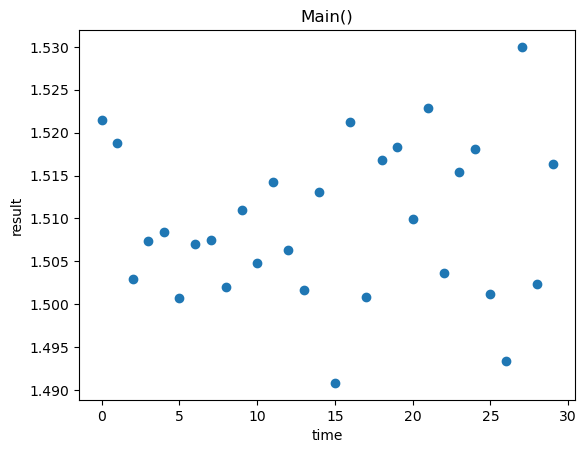

In [136]:

def plot_dot(results):
    plt.plot(results, 'o')
    plt.xlabel('time')
    plt.ylabel('result')
    plt.title('Main()')
    plt.show()

plot_dot(results)



In [137]:
def calculate_95_confidence_interval(data):
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # 使用样本标准差
    se = std / np.sqrt(len(data))  # 计算标准误差
    interval = stats.t.interval(0.95, len(data)-1, loc=mean, scale=se)
    return interval
print(results)
# 计算95%置信区间
confidence_interval = calculate_95_confidence_interval(results)
print("95% 置信区间:", confidence_interval)

[1.5215067227014583, 1.5187395187083004, 1.5030014188399856, 1.5073899977105447, 1.5084279068259459, 1.5007355206616324, 1.507011928408937, 1.5074383126687168, 1.5020627301543052, 1.510992406307751, 1.5048143731171553, 1.5142950904232482, 1.5063213149452035, 1.501682559317944, 1.513123115597859, 1.4908348589222398, 1.5212312203730625, 1.5008723973503537, 1.5167734688712735, 1.5183237233308688, 1.5099264673998505, 1.5229044115972379, 1.5036153253022215, 1.515450194080186, 1.5181330867200074, 1.5011379693089197, 1.493429451994593, 1.5299857037715583, 1.502322284980338, 1.516303165245058]
95% 置信区间: (1.5062206166061736, 1.5130318264362765)


30次结果，95% 置信区间: (1.5062206166061736, 1.5130318264362765) 5000， 2，  beta = 30.时间4分钟